<a href="https://colab.research.google.com/github/EliTaub1/bio108_tutorial/blob/main/cephalopod_SDM_HW11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Species Distribution Model for the Squid *Todaropsis eblanae*
Inspired by:

Rongcheng, R., H. Yi, M. Jialing, Y. Ying, L. Fanning, W. Xiya, S. Xinyuan, L. Caigang, D. Yingen, H. Qinghai, Y. Jinxiang, and Q. Jianglong. 2025. The species distribution model based on the random forest algorithm reveals the distribution patterns of Neophocaena asiaeorientalis. Scientific Reports 15:10037.

--

Rongcheng et al investigated the distribution of the Yangtze Finless Porpoise (YFP), a critically endangered species, in order to answer which aquatic variables were most critical in determining YFP habitat preferences and use a SDM to determine which areas were most likely to contain YFP. While they did not have any explicit hypotheses, they expected to see certain that aquatic factors would be more important in predicting YFP distributions than others and that a SDM would differentiate between regions which were and were not suitable for YFP.

They found that phosphate concentration and cyanobacteria density were the most important factors in predicting YFP distribution, along with noting that the use of absence rather than pseudo-absence points (like were used there) would be quite useful in constructing better SDMs.

--

Here, we use work from the cephalopod distribution dataset from Luna et al (2025) (consisting of cephalopod presence/absence from bottom trawls conducted between 2004 and 2012) to implement a Random Forest Species Distribution Model to predict the distribution of the squid *Todaropsis eblanae* in the Canary Current.

Inspired by the analysis of Rongcheng et al, we hope to answer what environmental variables will be most predictive of *Todaropsis eblanae* presence/absence and which regions *Todaropsis eblanae* will be predicted to occupy.

We hypothesize that dissolved oxygen and salinity are critical for determining which habitats are occupied by *Todaropsis eblanae*, as these variables were identified by Luna et al as a critical factor in predicting distribution of cephalopod species. Thus, we predict a random forest model will select these two variables as some of the most important variables for determining *Todaropsis eblanae*.

(Note: The importing packages, data preprocessing steps, and beginning of the analysis are taken from Homework 10.)

## Importing and installing packages
First, we install and import necessary packages that we will use in this analysis.

In [77]:
#install packages
! pip install rasterio rioxarray rasterstats pyo_oracle earthpy

In [78]:
#import packages
from google.colab import drive #allows access to data files in Google Drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.plot
from shapely.geometry import Point
import rasterstats
import os
import pyo_oracle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import earthpy as et


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Data

### Cephalopod Distribution
The data from Luna et al were saved as a Excel (.xlsx) file. For the purposes of this tutorial, they have already been covnerted to a .csv and uploaded to Google Drive.

We start by importing the data as a csv before turning the Longitude and Latitude values into spatial points that can be read as a GeoDataFrame.

In [79]:
#Import cephalopod data
cephalopod_path = "/content/drive/MyDrive/Colab Notebooks/Supporting_data_-_Cephalopods_distribution_paper.csv" #path within google drive, modify as needed
cephalopod = pd.read_csv(cephalopod_path)

#create GPD with cephalopod locations as spatial points
cephalopod_coords = cephalopod[["Long L", "Latit L"]]
cephalopod_coords = cephalopod_coords.to_numpy()
cephalopod_locations = [Point(xy) for xy in cephalopod_coords] #converts coordinate array into spatial points

cephalopod_locations = gpd.GeoDataFrame(cephalopod_locations,
                                  columns=['geometry'],
                                  crs="epsg:4326")
#add family data for each data point
cephalopod_locations["Family"] = cephalopod["Family"]
cephalopod_locations["Species"] = cephalopod["Species"]

#remove NA locations
cephalopod_locations = cephalopod_locations.loc[(cephalopod_locations.is_empty) == False]

### Envrionmental Variables
Now, we add in our oceanographic data from Bio-ORACLE (https://bio-oracle.org/index.php). Bio-ORACLE has an associated package, pyo_oracle, which makes it easy to acquire Bio-ORACLE datasets and download them directly into our directory!

First, we filter layers to get only the ones we desire and then we download these layers in the temporal and geographical range used in the reference study.

In [80]:
# Get full list of layers available
bio_oracle_layers = pyo_oracle.list_layers()

#reset pyo_oracle data from previous uses and then recreate folder
os.system('rm -rf /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')
os.system('mkdir /usr/local/lib/python3.11/dist-packages/pyo_oracle/data/')

#Select only layers of variables taken during the baseline period (2000-2018/2019/2020)
baselineLayers = bio_oracle_layers[bio_oracle_layers["datasetID"].str.contains("baseline")]
#Select only layers of variables taken at the benthic layer (as this is where the bottom trawls were conducted)
usedLayers = baselineLayers[baselineLayers["datasetID"].str.contains("depthmean")]

# Define constraints on layers to be in desired temporal range and latitude/longitude range. Here, we use the constraints of our reference study.y
constraints = {
    "time>=": "2004-01-01T00:00:00Z",
    "time<=": "2012-01-01T12:00:00Z",
    "time_step": 1,
    "latitude>=": 8,
    "latitude<=": 36,
    "latitude_step": 1,
    "longitude>=": -20,
    "longitude<=": 11,
    "longitude_step": 1
}

#Download layers using the IDs remaining after we've filtered
for title in usedLayers.datasetID:
  pyo_oracle.download_layers(title, constraints=constraints, skip_confirmation = True)

Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/chl_baseline_2000_2018_depthmean_2025-04-03-165708.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/dfe_baseline_2000_2018_depthmean_2025-04-03-165711.nc'. File size is 31.9 MB.
Constraints are:
{'time>=': '2004-01-01T00:00:00Z', 'time<=': '2012-01-01T12:00:00Z', 'time_step': 1, 'latitude>=': 8, 'latitude<=': 36, 'latitude_step': 1, 'longitude>=': -20, 'longitude<=': 11, 'longitude_step': 1}
Download finished at '/usr/local/lib/

In [81]:
#Reference: https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff
import xarray as xr
import rioxarray as rio

#Create save location for files
save_folder = '/content/oceandata/'
os.system(('mkdir /content/oceandata/'))

#List all files in the directory with .nc suffix
pyo_directory = "/usr/local/lib/python3.11/dist-packages/pyo_oracle/data/"
nc_filenames = os.listdir(pyo_directory)
nc_filenames = [s for s in nc_filenames if ".nc" in s]

#Rewrite nc as a .tif as save
for filename in nc_filenames:
  #open file with name suffix
  variable_path = pyo_directory + filename
  variable = xr.open_dataset(variable_path)
  #only extract the data variable with "mean" in the name
  var_name = [s for s in variable._variables if "mean" in s]
  var_data = variable[var_name[0]]
  #convert var_data into a format where it can be saved as .tif
  var_data = var_data.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
  var_data = var_data.rio.write_crs("epsg:4326", inplace=True)
  #save var_data
  save_loc = save_folder + var_name[0] + ".tif"
  var_data.rio.to_raster(save_loc)

### Combining Data Sources

Now, we extract envriomental data for each of the datapoints and add it back to the cephalopod location GeoDataFrame.

In [82]:
tif_filenames = os.listdir(save_folder)

for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))

  #extract envrionmental variable data
  variable_results = rasterstats.point_query(
      cephalopod_locations,
      variable_raster.read(1),
      nodata = variable_raster.nodata,
      affine = variable_raster.transform,
      interpolate='nearest'
  )
  #add envrionmental variable data back to cephalopod data
  cephalopod_locations[filename.replace(".tif",'')] = variable_results

#remove NA values
cephalopod_locations = cephalopod_locations.dropna()

##Analysis

First, we create a list of points where the species both was and was not found.

In [83]:
#Create locations where study species was found
tod_ebl_locations = cephalopod_locations[cephalopod_locations["Species"] == "Todaropsis eblanae"]
tod_ebl_locations = tod_ebl_locations.drop_duplicates(subset = "geometry") #remove duplicate locations
tod_ebl_locations["tod_ebl"] = True

#Create locations where study species was not found
other_locations = cephalopod_locations[~ cephalopod_locations["geometry"].isin(tod_ebl_locations.geometry)]
other_locations = other_locations.drop_duplicates(subset = "geometry") #remove duplicate locations
other_locations["tod_ebl"] = False

#Combine dataframes into single entry
frame_concat = [tod_ebl_locations, other_locations]
location_frame = pd.concat(frame_concat)

Now, let's use the Random Forest Classifier model in SciKit Learn to create our model for the SDM.

In [84]:
#Create training and test data
location_data = location_frame.drop(["geometry", "Family", "Species","tod_ebl"], axis = 1)
location_target = location_frame.tod_ebl
traindata, testdata, traintarget, testtarget = train_test_split(location_data, location_target, random_state = 47)

#Feed data into RandomForestClassifier
model = RandomForestClassifier(n_estimators=5000, random_state=0)
model.fit(traindata, traintarget)

#Generate and test predictions
pred = model.predict(testdata)
predaccuracy = [pred == testtarget]

Now that we've created this model, we can run the model to make predictions for all points within the study area.

In [85]:
tif_filenames = os.listdir(save_folder)

#create a placeholder array of zeroes to hold the data from the environmental variables
holderArray = np.zeros((12, 561, 621))
i = 0

for filename in tif_filenames:
  #open with rasterio
  variable_raster = rasterio.open((save_folder + filename))
  #add data from raster to the holderArray
  holderArray[[i]] = variable_raster.read(1)
  i = i + 1

#reformat the data to have 348381 rows with each of the 12 envrionmental variables
newHolder = pd.DataFrame(holderArray.reshape(12, 348381).transpose(1,0))

#use our random forest model on the new data
holderpred = model.predict(newHolder)
#reformat the new data to be plottable by coercing to be integer
holderpred = holderpred.reshape(561,621).astype(int)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Now, let's plot our SDM!

**NOTE for Prof Chang: Was unable to successfully add a map of land areas to contextualize where this is taking place; how do I convert the holderpred back to the coordinate system which it represents?**

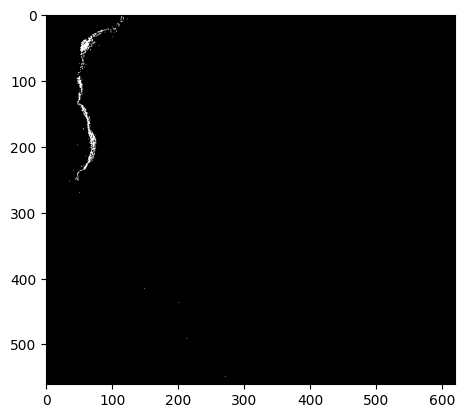

In [86]:
#data = et.data.get_data('spatial-vector-lidar')
#os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
#worldBound_path = os.path.join("data", "spatial-vector-lidar", "global",
#                               "ne_110m_land", "ne_110m_land.shp")
#worldBound = gpd.read_file(worldBound_path)

#Plot the holderpred array, with white marking predicted Tod_elb locations
fig, ax = plt.subplots()
plt.imshow(holderpred, cmap="gray")

We can now see a predicted distribution of *Todaropsis eblanae*! Even in areas where we have not surveyed, our model predicts habitat suitability or lack thereof, which is quite critical considering that it would take immense effort to survey in every 0.05 degree of latitude and longitude on the map.

But which variables have the greatest importance in limiting *Todaropsis eblanae* distribution?

Via Rongcheng et al, we can use our Random Forest to determine which variables have the greatest importance.

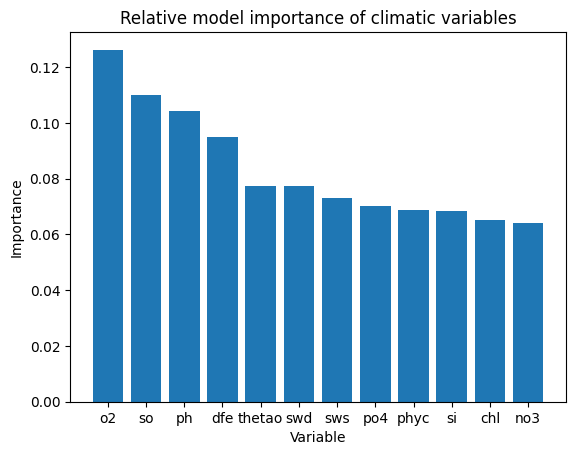

In [87]:
#find importance values
importance = model.feature_importances_

#determine corresponding labels
labels = np.array(location_data.columns)
#format labels so that they no longer include mean!
for i in range(12): labels[i] = labels[i].split("_")[0]
#convert to series with labels
labeled_importance = pd.Series(importance, labels)
#sort values from greatest to least
labeled_importance = labeled_importance.sort_values(ascending = False)

#plot labeled importance
fig, ax = plt.subplots()

#use bar plot
ax.bar(labeled_importance.index, labeled_importance)

#Set plot labels
ax.set_ylabel('Importance')
ax.set_xlabel('Variable')
ax.set_title('Relative model importance of climatic variables')

plt.show()

The three most importance variables are dissolved oxygen (o2), salinity (so), and pH.

While these variables differ from what Rongcheng et al found regarding the distribution of the Yangtze Finless Porpoise, this is largely in accordance with our hypothesis, indicating that these variables are likely major drivers in limiting *Todaropsis eblanae* distribution. However, it is worth noting this could be in part due to spatial autocorrelation, as Luna et al noted that oxygen and salinity had significant relationships with latitude in the Canary Current and thus this observed relationship may be driven by some confounding variable associated with latitude of location rather than oxygen and salinity themselves.